## Аннотация:
В этом ноутбуке описано решение учебной задачи на Kaggle, являющейся заданием с базового потока
DLSchool, весна 2023
- ссылка на задачу: https://www.kaggle.com/competitions/advanced-dls-spring-2021

In [313]:

# Импортируем все общие вещи которые нам понадобятся
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import roc_auc_score
# Импортируем модели и композиции моделей
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from catboost import CatBoostClassifier, Pool, cv
from sklearn.ensemble import RandomForestClassifier

In [263]:
# Загрузим данные и посмотрим на них
train = pd.read_csv('./train.csv')

train

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5277,3,30.40,82.15,Male,0,No,No,No,No phone service,DSL,No,No,No,Yes,No,No,Month-to-month,No,Electronic check,0
5278,50,44.45,2188.45,Male,0,Yes,No,No,No phone service,DSL,Yes,No,No,Yes,Yes,No,One year,Yes,Bank transfer (automatic),0
5279,1,55.05,55.05,Male,0,No,No,Yes,No,DSL,No,No,Yes,Yes,No,No,Month-to-month,No,Mailed check,0
5280,29,76.00,2215.25,Female,0,No,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Credit card (automatic),0


In [264]:
# посмотрим на то, сколько у нас пропущенных данных:
print(train.isna().value_counts()) # таких данных нет!

# убедимся, что пропущенных данных нет:
assert np.all(train.dropna()) == np.all(train)

ClientPeriod  MonthlySpending  TotalSpent  Sex    IsSeniorCitizen  HasPartner  HasChild  HasPhoneService  HasMultiplePhoneNumbers  HasInternetService  HasOnlineSecurityService  HasOnlineBackup  HasDeviceProtection  HasTechSupportAccess  HasOnlineTV  HasMovieSubscription  HasContractPhone  IsBillingPaperless  PaymentMethod  Churn
False         False            False       False  False            False       False     False            False                    False               False                     False            False                False                 False        False                 False             False               False          False    5282
dtype: int64


In [265]:
# возьмем любезно предоставленные авторами задания лейблы колонок
# Числовые признаки
num_cols = [
    'ClientPeriod',  'MonthlySpending',  'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex', 'IsSeniorCitizen', 'HasPartner',
    'HasChild', 'HasPhoneService', 'HasMultiplePhoneNumbers',
    'HasInternetService', 'HasOnlineSecurityService', 'HasOnlineBackup',
    'HasDeviceProtection', 'HasTechSupportAccess',  'HasOnlineTV',
    'HasMovieSubscription', 'HasContractPhone', 'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

# получим X_train и y_train
X_train = train[feature_cols]
y_train = train[target_col]

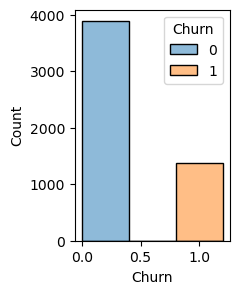

In [266]:
# Проанализируем данные
# Начнем с ответа на вопрос, сбалансирован ли датасет по классам:
plt.figure(figsize=(2, 3))

a = sns.histplot(data = train, x = 'Churn', binwidth = 0.4, hue = 'Churn')

# достаточно сбалансирован, разница в численности классов меньше чем в 3 раза

<Figure size 400x600 with 0 Axes>

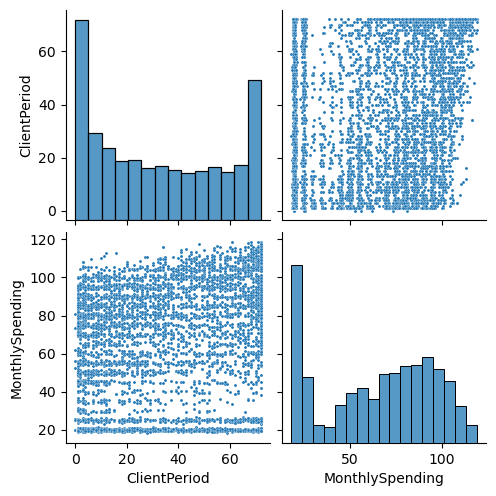

In [267]:
# посмотрим на распределение количественных признаков и наличие их взаимных зависимостей
plt.figure(figsize = (4, 6))
sns.pairplot(data=train[num_cols], plot_kws={"s": 5});

# в обоих случаях признаки распределены достаточно равномерно, зависимости между признаками нет
# monthly spendig похож на нормальное распределение за исключением большой группы тех кто тратит меньше всех


In [268]:
# Мы видим, что pairplot для колонки TotalSpent построить не удалось. Посмотрим, в чем дело:
train.info()  # TotalSpent dtype = 'object'!

# проверим можно ли привести его к числовому виду
try: 
    train['TotalSpent'].apply(float)
except Exception:
    print('не выходит')  # получаем ошибку



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

In [269]:
# посмотрим, что за значения выдают ошибку:
bad_values = []
for i in range(len(train['TotalSpent'])):
    try:
        float(train['TotalSpent'][i])
    except Exception:
        bad_values.append(i)
# посмотрим на эти значения
train.iloc[bad_values, :]  # в них TotalSpent неизвестен, стоит пробел ''.


,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1048,0,25.75,,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
1707,0,73.35,,Female,0,Yes,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,0
2543,0,19.70,,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,0
3078,0,80.85,,Female,0,Yes,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,0
3697,0,20.00,,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4002,0,61.90,,Male,0,No,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),0
4326,0,25.35,,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4551,0,52.55,,Female,0,Yes,Yes,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),0
4598,0,56.05,,Female,0,Yes,Yes,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),0


In [270]:
# обновим наш датасет чтобы в этом месте в колонке TotalSpent были NaN
train2 = train.replace(' ', np.nan)
# проверим, что получилось
print(train2.isna().value_counts())
# создадим вариант датасета с которым сможет работать sns.pairplot
train2 = train2.dropna()
train2['TotalSpent'] = train2['TotalSpent'].apply(float)

# обновим выборку для тренировки без пропущенных значений TotalSpent
X_train2 = train2[feature_cols]
y_train2 = train2[target_col]

ClientPeriod  MonthlySpending  TotalSpent  Sex    IsSeniorCitizen  HasPartner  HasChild  HasPhoneService  HasMultiplePhoneNumbers  HasInternetService  HasOnlineSecurityService  HasOnlineBackup  HasDeviceProtection  HasTechSupportAccess  HasOnlineTV  HasMovieSubscription  HasContractPhone  IsBillingPaperless  PaymentMethod  Churn
False         False            False       False  False            False       False     False            False                    False               False                     False            False                False                 False        False                 False             False               False          False    5273
                               True        False  False            False       False     False            False                    False               False                     False            False                False                 False        False                 False             False               False          False

<Figure size 400x600 with 0 Axes>

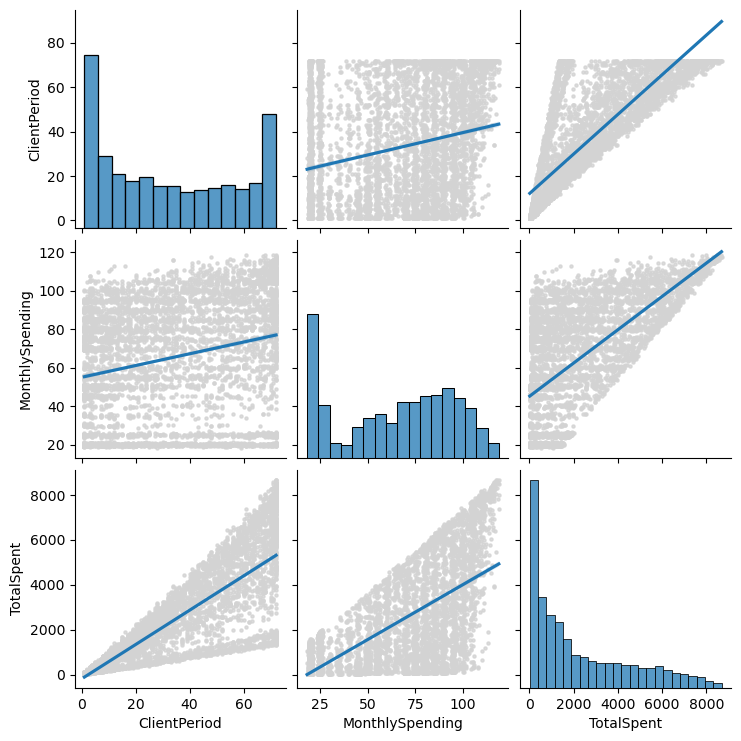

In [271]:
# построим pairplot и посмотрим на корреляции между численными переменными
plt.figure(figsize=(4, 6));
sns.pairplot(data=train2[num_cols], plot_kws={"scatter_kws": {"color": "lightgrey", "s": 5}}, kind='reg');
# У нас получилось построить эту зависимость. Видим, что totalspent сильно коррелирует с остальными числовыми признаками. 


In [272]:
# Проанализируем распределение категориальных признаков
# для этого получим лейблы и значения для каждой колонки в порядке соответствующем cat_cols
labels = []
values = []
for cat in cat_cols:
    labels.append(train[cat].value_counts().index)
    values.append(train[cat].value_counts().values)

(array([], dtype=float64), [])

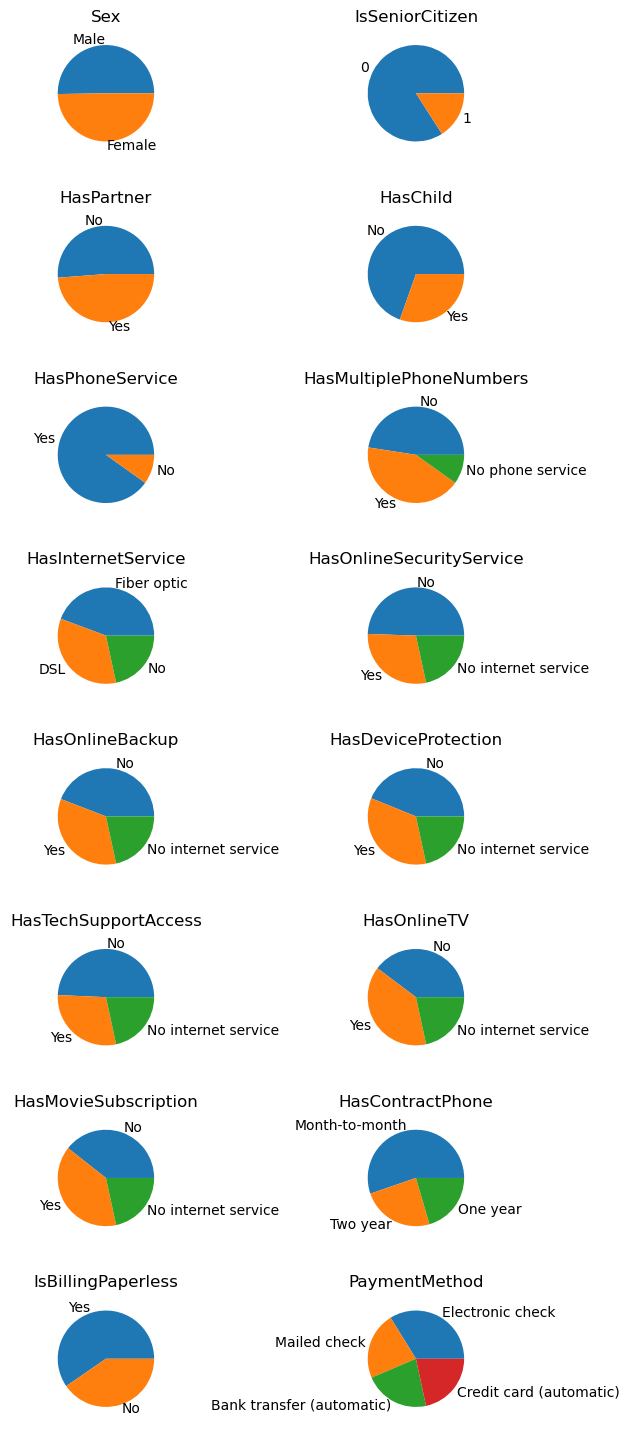

In [273]:
# построим круговые диаграммы для каждого категориального признака
categorical_plots = plt.figure(figsize=(6, 18))
for idx in range(len(cat_cols)):
    ax = categorical_plots.add_subplot(8, 2, idx+1)
    plt.pie(labels=labels[idx], x=values[idx])
    ax.set_title(cat_cols[idx], size=12, pad=8)

categorical_plots.subplots_adjust(wspace=1, hspace=0.5)
plt.xticks(fontsize=5)



Перейдем к обучению моделей. 
- X_train, y_train - на всем датасете
- X_train2, y_train2 - за исключением 9 образцов с пропущенными значениями в TotalSpent


In [304]:
# Лог регрессия

# one-hot encode categorical features
dummy_features = pd.get_dummies(train2[cat_cols])

# нормализуем количественные признаки
scaler = StandardScaler()
numeric_data_scaled = scaler.fit_transform(train2[num_cols])

# получим тренировочную выборку для лог-регрессии
logR_X = np.concatenate([numeric_data_scaled, dummy_features.values], axis=1)
logR_y = train2[target_col].to_numpy()



In [275]:
# Подберем силу регуляризации C с помощью LogisticRegressionCV

clf = LogisticRegressionCV(
    Cs=[1000, 100, 10, 1, 0.1, 0.01, 0.001],
    max_iter=1000, cv=5,  random_state=42, scoring='roc_auc', refit=True
                           )
clf.fit(logR_X, logR_y)

# при max_iter = 100 выдает ошибку

LogisticRegressionCV(Cs=[1000, 100, 10, 1, 0.1, 0.01, 0.001], cv=5,
                     max_iter=1000, random_state=42, scoring='roc_auc')

In [276]:
clf.score(logR_X, logR_y)  # roc-auc для тестовой выборки - 0.849
clf.C_  # наилучший параметр C (сила регуляризации) == 100

array([100.])

In [277]:
# повторим то же самое с поиском по сетке параметров с помощью GridSearchCV

parameters = {
    'C': [1000, 100, 10, 1, 0.1, 0.01, 0.001],
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
}
CV_model = GridSearchCV(estimator=LogisticRegression(max_iter=1000, penalty='l2'),
                        param_grid=parameters,
                        cv=5,
                        scoring='roc_auc',
                        n_jobs=-1,
                        refit=True
                        )
CV_model.fit(logR_X, logR_y)

# регуляризацию смотрели только l2, так как только она поддерживает все возможные солверы

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'C': [1000, 100, 10, 1, 0.1, 0.01, 0.001],
                         'solver': ['lbfgs', 'liblinear', 'newton-cg',
                                    'newton-cholesky', 'sag', 'saga']},
             scoring='roc_auc')

In [278]:
CV_model.best_score_  # наилучшее значение ROC-AUC - 0.845
CV_model.best_params_  # наилучшие параметры: C = 1000, solver = 'lbfgs'

# Любопытно, что score чуть меньше, чем для LogisticRegressionCV

# запомним лучшую модель, чтобы предсказывать тестовые данных
best_logR = CV_model.best_estimator_

In [334]:
# Проверим нашу логрегрессию на тестовых данных
test = pd.read_csv('./test.csv')

'''
В тестовых данных есть ровно одна строка-выброс с пропущенным значением
от нас просят, чтобы число строк в ответе
 было такое же как в тестовом файле, поэтому убирать мы ее не можем
Просто заменим это значение на 0
'''

test2 = test.replace(' ', 0)

# one-hot encode categorical features
dummy_features = pd.get_dummies(test2[cat_cols])

# нормализуем количественные признаки моделью, фитированой на тренировочных данных
numeric_data_scaled = scaler.transform(test2[num_cols])

# получим тестовую выборку для лог-регрессии
test_X_logR = np.concatenate([numeric_data_scaled, dummy_features.values], axis=1)





In [336]:
# напишем функцию для создания файлов ответа

def write_submission(model, X):
    predictions = np.round(model.predict_proba(X), 2)
    with open('submission.csv', 'w') as subm:
        subm.write('Id,Churn\n')
        for a in range(len(predictions)):
            subm.write(str(a)+','+str(predictions[:, -1][a])+'\n')


In [281]:
write_submission(clf, test_X_logR)

# После загрузки на kaggle получили ROC-AUC 0.84592. Баллы заработали, тестируем дальше :)

In [282]:
# Разберемся с градиентным бустингом с помощью catboost
# нормировать численные признаки и кодировать категориальные нам не требуется

# используем X_train2, y_train2 - строки, содержащие пустые поля, отброшены

# подберем оптимальное количество итераций с помощью валидационного датасета и встроенного параметра use_best_model = True
X_train, X_val, y_train, y_val = train_test_split(X_train2, y_train2, test_size=0.2, random_state=1905)

val_data = Pool(X_val, y_val, cat_features=cat_cols)
train_data = Pool(X_train, y_train, cat_features=cat_cols)

model = CatBoostClassifier(
    eval_metric='AUC',
    use_best_model=True,
    )
# eta - learning rate, reg_lambda - strength of l2 reg, num_trees - number of boosting iterations, depth - глубина дерева

# обучим модель
model.fit(train_data, verbose = 20, eval_set = val_data);


/opt/homebrew/anaconda3/lib/python3.10/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


Learning rate set to 0.045218
0:	test: 0.8067293	best: 0.8067293 (0)	total: 21.9ms	remaining: 21.9s
20:	test: 0.8385635	best: 0.8385635 (20)	total: 105ms	remaining: 4.91s
40:	test: 0.8436030	best: 0.8436030 (40)	total: 188ms	remaining: 4.4s
60:	test: 0.8456558	best: 0.8456558 (60)	total: 255ms	remaining: 3.92s
80:	test: 0.8468688	best: 0.8468688 (80)	total: 328ms	remaining: 3.72s
100:	test: 0.8472441	best: 0.8474775 (94)	total: 399ms	remaining: 3.55s
120:	test: 0.8474134	best: 0.8474775 (94)	total: 476ms	remaining: 3.46s
140:	test: 0.8471136	best: 0.8474775 (94)	total: 555ms	remaining: 3.38s
160:	test: 0.8472899	best: 0.8474775 (94)	total: 625ms	remaining: 3.25s
180:	test: 0.8470129	best: 0.8474775 (94)	total: 712ms	remaining: 3.22s
200:	test: 0.8472922	best: 0.8474775 (94)	total: 793ms	remaining: 3.15s
220:	test: 0.8465186	best: 0.8474775 (94)	total: 883ms	remaining: 3.11s
240:	test: 0.8457863	best: 0.8474775 (94)	total: 972ms	remaining: 3.06s
260:	test: 0.8449395	best: 0.8474775 (94)

In [283]:
# предскажем вероятности классов в тестовом датасете с помощью catboost
write_submission(model, test2)
# На тестовых данных AUC = 0.853, сильно лучше чем было!

In [284]:
# попробуем встроенную в catboost кросс-валидацию для подбора числа итераций

cv_data = Pool(X_train2, y_train2, cat_features = cat_cols)
parameters = {'iterations' : 100, 'loss_function' : 'Logloss', 'eval_metric' : 'AUC'}
scores = cv(dtrain = cv_data, as_pandas = True, plot = False,  params = parameters, fold_count = 5)


Training on fold [0/5]
0:	test: 0.7313926	best: 0.7313926 (0)	total: 5.46ms	remaining: 540ms
1:	test: 0.7691340	best: 0.7691340 (1)	total: 10.1ms	remaining: 493ms
2:	test: 0.7733126	best: 0.7733126 (2)	total: 14.7ms	remaining: 474ms
3:	test: 0.7753566	best: 0.7753566 (3)	total: 17.5ms	remaining: 421ms
4:	test: 0.7737070	best: 0.7753566 (3)	total: 21.5ms	remaining: 409ms
5:	test: 0.7754981	best: 0.7754981 (5)	total: 24.6ms	remaining: 385ms
6:	test: 0.7762847	best: 0.7762847 (6)	total: 31.1ms	remaining: 413ms
7:	test: 0.7791616	best: 0.7791616 (7)	total: 36.9ms	remaining: 425ms
8:	test: 0.7814840	best: 0.7814840 (8)	total: 43.4ms	remaining: 439ms
9:	test: 0.7825049	best: 0.7825049 (9)	total: 49ms	remaining: 441ms
10:	test: 0.7840199	best: 0.7840199 (10)	total: 52.5ms	remaining: 425ms
11:	test: 0.7852844	best: 0.7852844 (11)	total: 55.2ms	remaining: 405ms
12:	test: 0.7853702	best: 0.7853702 (12)	total: 59.5ms	remaining: 398ms
13:	test: 0.7853842	best: 0.7853842 (13)	total: 62.6ms	remainin

In [285]:
# используем число итераций, определенное с помощью кросс-валидации, для обучения модели

model = CatBoostClassifier(num_trees=99)

# train the model
model.fit(X_train2, y_train2, cat_features=cat_cols)

write_submission(model, test2)
# получилось улучшить результат , AUC на тестовых данных = 0.8536


Learning rate set to 0.174685
0:	learn: 0.6332741	total: 2.09ms	remaining: 205ms
1:	learn: 0.5904734	total: 3.61ms	remaining: 175ms
2:	learn: 0.5551128	total: 5.15ms	remaining: 165ms
3:	learn: 0.5275130	total: 6.68ms	remaining: 159ms
4:	learn: 0.5070242	total: 8.24ms	remaining: 155ms
5:	learn: 0.4902831	total: 9.68ms	remaining: 150ms
6:	learn: 0.4766887	total: 10.9ms	remaining: 143ms
7:	learn: 0.4658310	total: 12.1ms	remaining: 137ms
8:	learn: 0.4575149	total: 13.7ms	remaining: 137ms
9:	learn: 0.4507148	total: 15.1ms	remaining: 134ms
10:	learn: 0.4453073	total: 16.6ms	remaining: 133ms
11:	learn: 0.4383101	total: 18.2ms	remaining: 132ms
12:	learn: 0.4323945	total: 19.9ms	remaining: 131ms
13:	learn: 0.4281177	total: 21.5ms	remaining: 131ms
14:	learn: 0.4248948	total: 23.3ms	remaining: 130ms
15:	learn: 0.4220809	total: 24.8ms	remaining: 128ms
16:	learn: 0.4201347	total: 26.2ms	remaining: 126ms
17:	learn: 0.4177592	total: 27.4ms	remaining: 123ms
18:	learn: 0.4161063	total: 28.3ms	remaining

/opt/homebrew/anaconda3/lib/python3.10/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


Воспользуемся встроенным в CatBoost поиском по сетке параметров:

In [286]:
model = CatBoostClassifier(eval_metric = 'AUC:hints=skip_train~false', silent = True)

# get data
encoder = OneHotEncoder()
one_hot_X = encoder.fit_transform(X_train2[cat_cols])

# train the model
model.grid_search({'depth': [3,5,7,9],
                'l2_leaf_reg': [1, 3, 5, 7, 9],
                'random_strength' : [0.5, 1, 2, 3],
                },
                X=train_data,
                refit=True,
                cv=5,  
                )



bestTest = 0.8532973346
bestIteration = 536

0:	loss: 0.8532973	best: 0.8532973 (0)	total: 3.59s	remaining: 4m 43s

bestTest = 0.8525811887
bestIteration = 279

1:	loss: 0.8525812	best: 0.8532973 (0)	total: 7.28s	remaining: 4m 43s

bestTest = 0.8527650123
bestIteration = 264

2:	loss: 0.8527650	best: 0.8532973 (0)	total: 10.7s	remaining: 4m 33s

bestTest = 0.8529526654
bestIteration = 296

3:	loss: 0.8529527	best: 0.8532973 (0)	total: 14.1s	remaining: 4m 28s

bestTest = 0.8524931066
bestIteration = 251

4:	loss: 0.8524931	best: 0.8532973 (0)	total: 17.8s	remaining: 4m 27s

bestTest = 0.8538985907
bestIteration = 726

5:	loss: 0.8538986	best: 0.8538986 (5)	total: 21.1s	remaining: 4m 20s

bestTest = 0.8534237132
bestIteration = 298

6:	loss: 0.8534237	best: 0.8538986 (5)	total: 24.3s	remaining: 4m 13s

bestTest = 0.8538871017
bestIteration = 317

7:	loss: 0.8538871	best: 0.8538986 (5)	total: 27.7s	remaining: 4m 9s

bestTest = 0.8531671262
bestIteration = 315

8:	loss: 0.8531671	best: 0.

KeyboardInterrupt: 

In [ ]:
model.best_score_

{'learn': {'Logloss': 0.37766315074182133, 'AUC': 0.8744201686744952}}

In [ ]:
model.tree_count_

1000

In [ ]:
model.get_params()

{'silent': True,
 'eval_metric': 'AUC:hints=skip_train~false',
 'random_strength': 3,
 'depth': 3,
 'l2_leaf_reg': 7}

In [ ]:
write_submission(model, test2)

## Подведем итоги:
- Тренировочные данные почти без пустых полей, сильного дисбаланса по классам нет
- Применения логистической регрессии достаточно для достижения AUC 0.84
- Дополнительный подбор солвера с помощью поиска по сетке параметров подтвердил, что наилучшим является солвер по умолчанию (`lbfgs`)
<br/><br/>
- Градиентный бустинг c помощью сatboost позволяет улучшить показатель целевой метрики до >0.853
- Наилучшим образом работает подбор числа итераций с помощью встроенной кросс-валидации
- Подбор скорости обучения catboost производит сам, значение depth по умолчанию работало лучше всего
<br/><br/>

p.s. я сначала написал свою функцию для создания файла ответа, потом увидел предлагаемую в ноутбуке :D

In [306]:
logR_y.shape

(5273,)

In [302]:
train2

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.20,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.90,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570.00,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5277,3,30.40,82.15,Male,0,No,No,No,No phone service,DSL,No,No,No,Yes,No,No,Month-to-month,No,Electronic check,0
5278,50,44.45,2188.45,Male,0,Yes,No,No,No phone service,DSL,Yes,No,No,Yes,Yes,No,One year,Yes,Bank transfer (automatic),0
5279,1,55.05,55.05,Male,0,No,No,Yes,No,DSL,No,No,Yes,Yes,No,No,Month-to-month,No,Mailed check,0
5280,29,76.00,2215.25,Female,0,No,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Credit card (automatic),0


In [307]:
rf_clf = RandomForestClassifier()
logR_X = np.concatenate([numeric_data_scaled, dummy_features.values], axis=1)
logR_y = train2[target_col].to_numpy()
X_train, X_val, y_train, y_val = train_test_split(logR_X, logR_y, test_size=0.2, random_state=1905)
rf_clf.fit(X_train, y_train)

RandomForestClassifier()

In [319]:
train_pred = rf_clf.predict(X_train)
val_pred = rf_clf.predict(X_val)
clf_train_score = roc_auc_score(y_train, train_pred)
clf_val_score = roc_auc_score(y_val, val_pred)
print(f'Случайный лес с параметрами по умолчанию приблизил тренировочную выборку с AUC {clf_train_score} \n и валидационный датасетс AUC {clf_val_score} ')


Случайный лес с параметрами по умолчанию приблизил тренировочную выборку с AUC 0.9979959595747674 
 и валидационный датасет с AUC 0.6812830699939582 


Похоже на переобучение. Подберем параметры с помощью GridSearch:

In [339]:

parameters = {
    'n_estimators' : [50, 100, 200, 400],
    'max_depth' : [5, 10, 20, None],
    'min_samples_split' : [2, 3, 5],
    'min_samples_leaf' : [1, 2, 3],
    'warm_start' : [True, False]}
CV_model = GridSearchCV(estimator=RandomForestClassifier(),
                        param_grid=parameters,
                        cv=5,
                        scoring='f1',
                        n_jobs=-1,
                        refit=True
                        )


In [340]:
CV_model.fit(logR_X, logR_y)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 20, None],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 5],
                         'n_estimators': [50, 100, 200, 400],
                         'warm_start': [True, False]},
             scoring='f1')

In [341]:
CV_model.best_params_

{'max_depth': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 50,
 'warm_start': True}

In [342]:
CV_model.best_score_

0.573174832669617

In [343]:
preds = CV_model.predict(logR_X)
roc_auc_score(logR_y, preds)

0.8117694676105869

In [344]:
write_submission(CV_model, test_X_logR )

Попробуем не скейлить численные признаки и закодировать категориальные только числами

In [357]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
encd = OrdinalEncoder()
cat_data = encd.fit_transform(train2[cat_cols])
train_X_forest = np.concatenate([cat_data, train2[num_cols].values], axis = 1)
train_y_forest = train2['Churn'].values

In [366]:
rf_clf2 = RandomForestClassifier()
X_train, X_val, y_train, y_val = train_test_split(train_X_forest, train_y_forest, test_size=0.2, random_state=1905)
rf_clf2.fit(X_train, y_train)

RandomForestClassifier()

In [367]:
clf_train_score = rf_clf2.score(X_train, y_train)
clf_val_score = rf_clf2.score(X_val, y_val)
print(f'Случайный лес с параметрами по умолчанию приблизил тренировочную выборку с AUC {clf_train_score} \n и валидационный датасет с AUC {clf_val_score} ')


(0.9983404457088667, 0.7848341232227488)

In [368]:
cat_data_test = encd.fit_transform(test2[cat_cols])
test_X_forest = np.concatenate([cat_data_test, test2[num_cols].values], axis = 1)
write_submission(rf_clf2, test_X_forest)